epoch 1, loss 0.0038, train acc 0.750, test acc 0.945
epoch 2, loss 0.0010, train acc 0.941, test acc 0.961
epoch 3, loss 0.0007, train acc 0.958, test acc 0.966
epoch 4, loss 0.0006, train acc 0.967, test acc 0.970
epoch 5, loss 0.0005, train acc 0.970, test acc 0.975
epoch 6, loss 0.0004, train acc 0.973, test acc 0.974
epoch 7, loss 0.0004, train acc 0.976, test acc 0.975
epoch 8, loss 0.0004, train acc 0.977, test acc 0.978
epoch 9, loss 0.0003, train acc 0.980, test acc 0.978
epoch 10, loss 0.0003, train acc 0.981, test acc 0.978


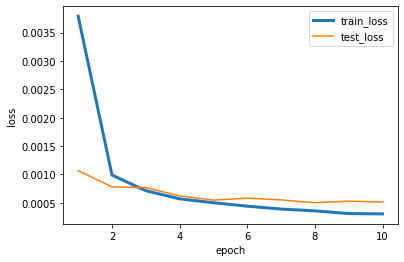

In [2]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt

mnist_train = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=False, download=True, transform=transforms.ToTensor())

batch_size = 200
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, (num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1,dtype=torch.float, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2,dtype=torch.float,requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, (num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs,dtype=torch.float,requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <=1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.randn(X.shape) < keep_prob).float()
    return mask * X / keep_prob

drop_prob1, drop_prob2 = 0.3, 0.5

def net(X, is_training = True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training:
        H1 = dropout(H1, drop_prob1)
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)
    return torch.matmul(H2, W3) + b3

def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

def evaluate_accuracy(data_iter, net):    
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):  
            net.eval()  #api文档：将模型设置成evaluation模式，仅仅当模型中有Dropout和BatchNorm是才会有影响。
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train()
        else:
            if('is_training' in net.__code__.co_varnames):
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

num_epochs, lr = 10, 106.0
loss = torch.nn.CrossEntropyLoss()

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params , lr):
    train_ls, test_ls, x_epoch = [], [], []
    for epoch in range(num_epochs):
        train_1_sum = 0.0
        train_1_test_sum = 0.0
        train_acc_sum = 0.0
        n = 0
        n_test = 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            if params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()

            l.backward()
            sgd(params, lr, batch_size)

            train_1_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim =1) == y).sum().item()
            n += y.shape[0]
        train_ls.append(train_1_sum / n)
        x_epoch.append(epoch + 1)
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / n, train_acc_sum / n, test_acc))

        for X_test, y_test in test_iter:
            y_hat = net(X_test)
            l = loss(y_hat, y_test).sum()
            train_1_test_sum += l.item()
            n_test += y_test.shape[0]
        test_ls.append(train_1_test_sum / n_test)


    plt.plot(x_epoch, train_ls, label="train_loss", linewidth=3)
    plt.plot(x_epoch, test_ls, label="test_loss", linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()


train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0085, train acc 0.441, test acc 0.816
epoch 2, loss 0.0049, train acc 0.678, test acc 0.863
epoch 3, loss 0.0039, train acc 0.748, test acc 0.883
epoch 4, loss 0.0034, train acc 0.784, test acc 0.892
epoch 5, loss 0.0031, train acc 0.806, test acc 0.902
epoch 6, loss 0.0028, train acc 0.823, test acc 0.908
epoch 7, loss 0.0027, train acc 0.836, test acc 0.912
epoch 8, loss 0.0025, train acc 0.845, test acc 0.915
epoch 9, loss 0.0024, train acc 0.851, test acc 0.918
epoch 10, loss 0.0023, train acc 0.857, test acc 0.921
epoch 11, loss 0.0022, train acc 0.865, test acc 0.924
epoch 12, loss 0.0021, train acc 0.870, test acc 0.927


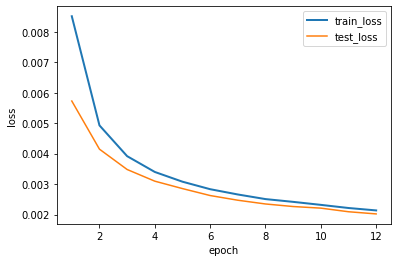

In [3]:
import torch.nn as nn
from torch.nn import init
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

mnist_train = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.MNIST(root='./Datasets/MNIST', train=False, download=True, transform=transforms.ToTensor())

batch_size = 200
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False,num_workers=0)

num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
drop_prob1, drop_prob2 = 0.3, 0.5


class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)


net = nn.Sequential(
     FlattenLayer(),
     nn.Linear(num_inputs, num_hiddens1),
     nn.ReLU(),
     nn.Dropout(drop_prob1),
     nn.Linear(num_hiddens1, num_hiddens2),
     nn.ReLU(),
     nn.Dropout(drop_prob2),
     nn.Linear(num_hiddens2, num_outputs),
     )

for params in net.parameters():
    init.normal_(params, mean=0, std=0.1)


def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval()
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train()
        else:
            if('is_training' in net.__code__.co_varnames):
                acc_sum += (net(X, is_training=False).argmax(dim=1) == y).float().sum().item()
            else:
                acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
num_epochs = 12

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, optimizer):
    train_ls, test_ls, x_epoch = [], [], []
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n = 0.0, 0.0, 0
        train_1_test_sum, n_test = 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

            train_1_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        train_ls.append(train_1_sum / n)
        x_epoch.append(epoch + 1)
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / n, train_acc_sum / n, test_acc))

        for X_test, y_test in test_iter:
            y_hat = net(X_test)
            l = loss(y_hat, y_test).sum()
            train_1_test_sum += l.item()
            n_test += y_test.shape[0]
        test_ls.append(train_1_test_sum / n_test)


    plt.plot(x_epoch, train_ls, label="train_loss", linewidth=2)
    plt.plot(x_epoch, test_ls, label="test_loss", linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()


train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, optimizer)